### Naive vs Marla

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

In [16]:
# Path to local CSV folder
csv_folder = "/home/george/Workshop/Interference/Results/traffic_generator_csvs"

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(csv_folder, "*.csv"))

In [17]:
def plot_p99_latency(csv_filenames, folder_path="/home/george/Workshop/Interference/Results/traffic_generator_csvs"):
    """
    Plots the P99 latency over time for selected CSV files, keeping only values below 20.
    
    Args:
        csv_filenames (list): List of CSV filenames (e.g., ["naive_v01.csv", "balanced_ramp.csv"]).
        folder_path (str): Folder where the CSV files are stored.
    """
    plt.figure(figsize=(12, 6))

    for filename in csv_filenames:
        full_path = os.path.join(folder_path, filename)
        if not os.path.exists(full_path):
            print(f"Warning: File not found: {full_path}")
            continue
        
        df = pd.read_csv(full_path)
        df['Minute'] = pd.to_numeric(df['Minute'], errors='coerce')
        df['P99_Latency'] = pd.to_numeric(df['P99_Latency'], errors='coerce')
        df = df[df['P99_Latency'] < 20]  # Keep only values below 20
        
        label = filename.replace(".csv", "")
        plt.plot(df['Minute'], df['P99_Latency'], marker='o', linewidth=2, label=label)

    plt.title("P99 Latency Over Time per Experiment")
    plt.xlabel("Minute")
    plt.ylabel("P99 Latency (ms)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(range(1, 31))  # Set x-axis ticks to integers 1 to 30
    plt.show()

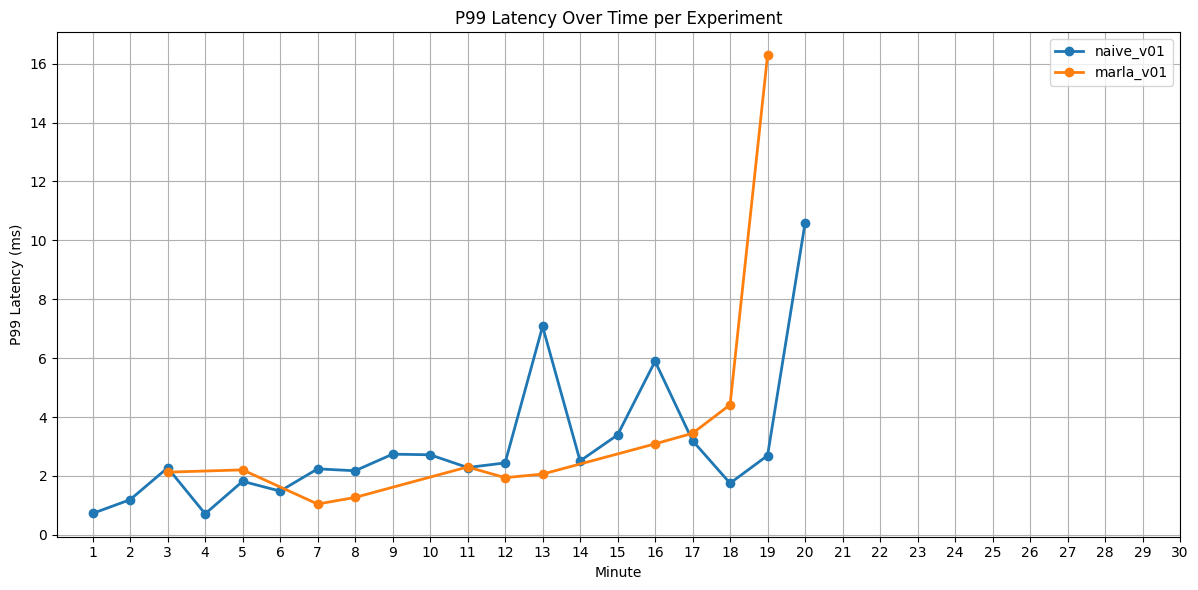

In [10]:
plot_p99_latency(["naive_v01.csv", "marla_v01.csv"])


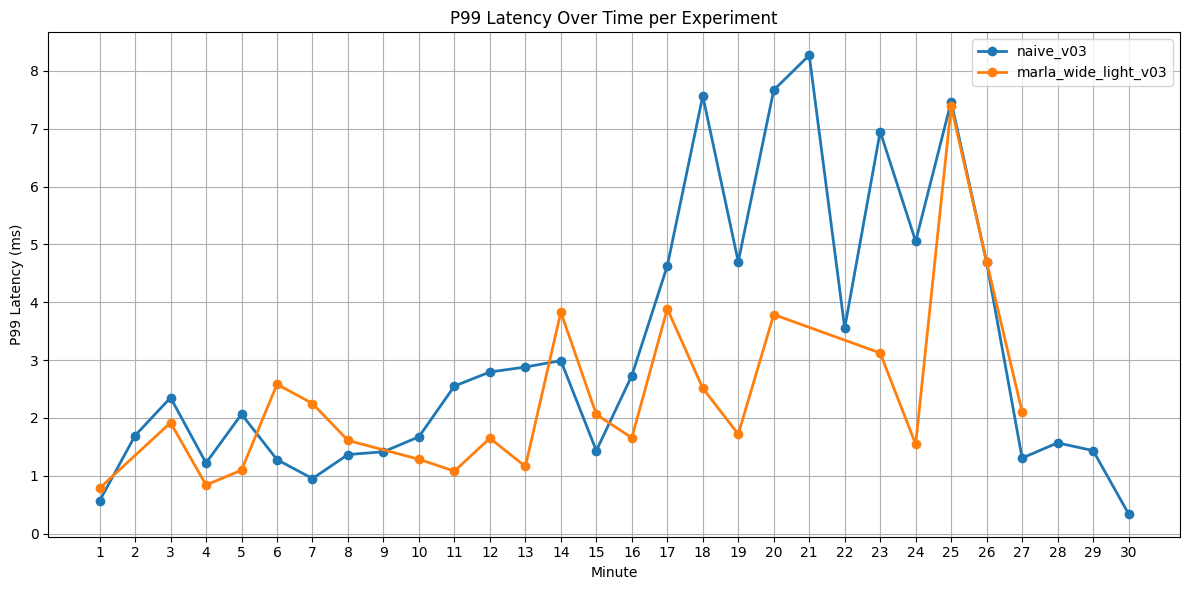

In [18]:
# plot for naive 02 and naive 03
plot_p99_latency(["naive_v03.csv", "marla_wide_light_v03.csv"])